In [1]:
!pip install numpy opencv-python

# Основные функции

In [152]:
import zlib
import bz2
import lzma
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [173]:
# Предикторы
# ......................
# .... | C | B | D | ...
# .... | A | X |   | ...   
# ......................
# X - предсказываемый пиксель

# Пустой предиктор 
def predictor_none(row: int, col: int, image: np.ndarray) -> int:
    return 0

# Левый предиктор: predict(A)
def predictor_left(row: int, col: int, image: np.ndarray) -> int:
    return int(image[row, col - 1]) if col > 0 else 0

# Верхний предиктор: predict(B)
def predictor_up(row: int, col: int, image: np.ndarray) -> int:
    return int(image[row - 1, col]) if row > 0 else 0

# Срднее: predict((A + B) / 2)
def predictor_average(row: int, col: int, image: np.ndarray) -> int:
    a = predictor_left(row, col, image)
    b = predictor_up(row, col, image)
    return (a + b) // 2

# Ближайшая из A,B,C к A + B - C
def predictor_paeth(row: int, col: int, image: np.ndarray) -> int:
    a = predictor_left(row, col, image)
    b = predictor_up(row, col, image)
    c = int(image[row - 1, col - 1]) if row > 0 and col > 0 else 0
    p = a + b - c
    pa, pb, pc = abs(p - a), abs(p - b), abs(p - c)
    return a if pa <= pb and pa <= pc else b if pb <= pc else c

# Предикторы, из которых выбираем для каждого пикселя свой
PREDICTORS = [
    predictor_none, 
    predictor_left, 
    predictor_up,
    predictor_average,
    predictor_paeth
]

# По изображению находим его сериализованную матрицу ошибок
def image2residuals(image: np.ndarray, N=10) -> np.ndarray:
    """
    Кодирует изображение в вектор остатков (residuals),
    при этом первый пиксель не предсказывается, а сохраняется как есть.

    Параметры:
        image - grayscale изображение (uint8)
        N - глубина окна ошибок для адаптивного выбора предиктора

    Возвращает:
        1D-массив остатков (int16)
    """
    if len(image.shape) != 2:
        raise ValueError("Only grayscale images are supported")
    
    image = image.astype(np.int16)
    h, w = image.shape
    prediction_image = np.zeros_like(image, dtype=np.int16)
    residuals = np.zeros_like(image, dtype=np.int16)

    for row in range(h):
        row_errors = np.zeros((N, len(PREDICTORS)))

        for col in range(w):
            actual = int(image[row, col])

            if col == 0:
                if row == 0:
                    # Первый пиксель всего изображения сохраняем как есть
                    prediction_image[row, col] = 0
                    residuals[row, col] = actual
                else:
                    # Предсказываем первый пиксель строки по верху
                    pred = predictor_up(row, col, image)
                    prediction_image[row, col] = pred
                    residuals[row, col] = actual - pred
                continue

            # Выбираем лучший предиктор по средним ошибкам за последние N шагов
            if col > 1:
                row_means = row_errors[0:min(col, N), :].mean(axis=0)
                best_idx = int(np.argmin(row_means))
            else:
                best_idx = 1

            pred = PREDICTORS[best_idx](row, col, image)
            prediction_image[row, col] = pred
            residuals[row, col] = actual - pred

            # Обновляем матрицу ошибок
            row_errors = np.roll(row_errors, shift=1, axis=0)
            for k, fn in enumerate(PREDICTORS):
                p = fn(row, col, image)
                row_errors[0, k] = (actual - p) ** 2

    return residuals.reshape(-1)

# По одномерной матрице ошибок и размерам изображения находим изображение
def residuals2image(residuals: np.ndarray, h: int, w: int, N=10) -> np.ndarray:
    """
    Восстанавливает изображение из массива остатков.
    Первый пиксель восстанавливается напрямую,
    остальные — по предсказаниям и остаткам.

    Параметры:
        residuals — 1D массив остатков (int16)
        h, w — размеры изображения
        N — глубина окна ошибок

    Возвращает:
        Восстановленное изображение (uint8)
    """
    residuals = residuals.reshape((h, w))
    image = np.zeros((h, w), dtype=np.int16)

    for row in range(h):
        row_errors = np.zeros((N, len(PREDICTORS)))

        for col in range(w):
            if col == 0:
                if row == 0:
                    # Первый пиксель всего изображения восстанавливаем напрямую
                    image[row, col] = residuals[row, col]
                else:
                    # Предсказываем первый пиксель строки по верху
                    pred = predictor_up(row, col, image)
                    image[row, col] = pred + residuals[row, col]
                continue

            if col > 1:
                row_means = row_errors[0:min(col, N), :].mean(axis=0)
                best_idx = int(np.argmin(row_means))
            else:
                best_idx = 1

            pred = PREDICTORS[best_idx](row, col, image)
            image[row, col] = pred + residuals[row, col]

            # Обновляем ошибки
            row_errors = np.roll(row_errors, shift=1, axis=0)
            for k, fn in enumerate(PREDICTORS):
                p = fn(row, col, image)
                row_errors[0, k] = (image[row, col] - p) ** 2

    return np.clip(image, 0, 255).astype(np.uint8)

# Проверка кодера и декодера изображений

Проверка работы на примере

In [174]:
path_images = os.getcwd() + "\\images"

img = cv2.imread(path_images + "\\example.jpg")

if img is None:
    raise FileNotFoundError("example.jpg not found")

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

N = 10

residuals = image2residuals(img_gray, N)

reconstructed_image = residuals2image(residuals, img_gray.shape[0], img_gray.shape[1], N)

print("Совпадает ли восстановленное изображение с оригиналом?", np.allclose(img_gray, reconstructed_image))

Совпадает ли восстановленное изображение с оригиналом? True


Проверка распределния отклонения (должно быть похоже на нормальное с мат. ожиданием 0)

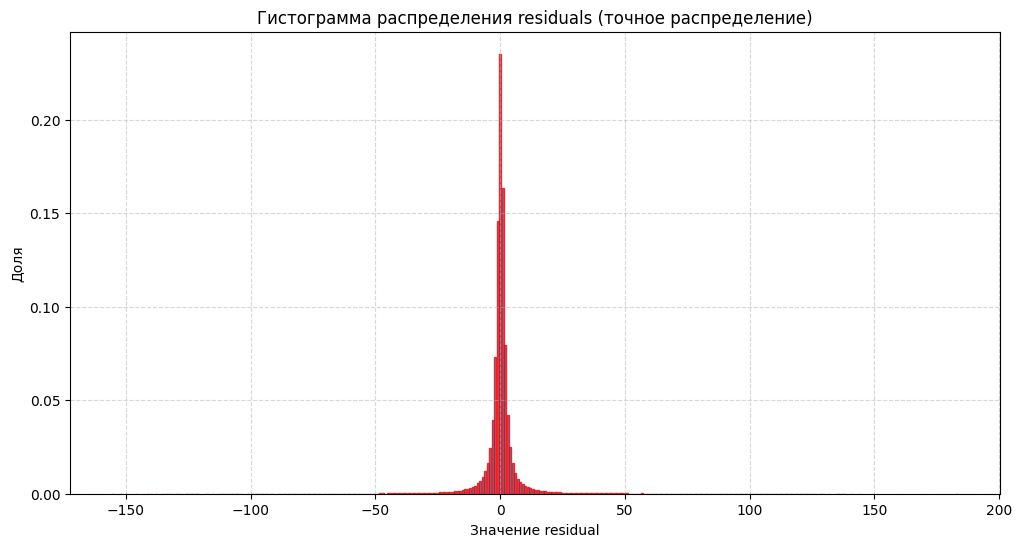

In [175]:
import numpy as np
import matplotlib.pyplot as plt

unique_values, counts = np.unique(residuals, return_counts=True)

plt.figure(figsize=(12, 6))
plt.bar(unique_values, counts/counts.sum(), width=0.8, 
        edgecolor='red', alpha=0.8)
plt.title('Гистограмма распределения residuals (точное распределение)')
plt.xlabel('Значение residual')
plt.ylabel('Доля')
plt.grid(True, linestyle='--', alpha=0.5)

value_frequency = np.column_stack((unique_values, counts))
# print("Массив значений и их частот:")
# print(value_frequency)

# Выбор кодера для полученной матрицы ошибок

Смотрим различные варианты кодировать массива, где значения будут в промежутке [-255 : 255]. Большинство значений близки к 0, поэтому это стоит учитывать для выбора наилучшего кодера

Для многих методов нужны положительные значения, поэтому вместе с residuals будет использоваться массив residuals_shifted, в котором числа смещены на min(residual), чтобы минимальное число было 0.

In [187]:
min_val = residuals.min()
residuals_shifted = residuals - min_val

## Арифметическое кодирование

### Реализация для статического арифмитического кодирования

In [177]:
from collections import Counter, deque

class ArithmeticEncoder:
    def __init__(self, bit_precision):
        self.bit_precision = bit_precision
        self.max_num = 2 ** bit_precision
        self.low = 0
        self.high = self.max_num - 1
        self.pending_bits = 0
        self.encode = ""

        self.full_mask = (1 << bit_precision) - 1
        self.highest_bit = 1 << (bit_precision - 1)
        self.pre_highest_bit = self.highest_bit >> 1

    def _shift(self):
        bit = self.low >> (self.bit_precision - 1)
        self.encode += str(bit)
        for _ in range(self.pending_bits):
            self.encode += str(bit ^ 1)
        self.pending_bits = 0

    def encode_symbol(self, symb_interval):
        interval_start, interval_end = symb_interval
        range_size = self.high - self.low + 1

        new_low = self.low + interval_start * range_size // (self.max_num - 1)
        new_high = self.low + interval_end * range_size // (self.max_num - 1) - 1

        self.low = new_low
        self.high = new_high

        while ((self.low ^ self.high) & self.highest_bit) == 0:
            self._shift()
            self.low = ((self.low << 1) & self.full_mask)
            self.high = ((self.high << 1) & self.full_mask) | 1

        while (self.low & ~self.high & self.pre_highest_bit) != 0:
            self.pending_bits += 1
            self.low = (self.low << 1) ^ self.highest_bit
            self.high = ((self.high ^ self.highest_bit) << 1) | self.highest_bit | 1

    def finish(self):
        self.encode += '1'


class ArithmeticDecoder:
    def __init__(self, encode_text, len_text, bit_precision):
        self.bit_precision = bit_precision
        self.max_num = 2 ** bit_precision
        self.low = 0
        self.high = self.max_num - 1

        self.input = deque(encode_text)
        self.len_text = len_text
        self.code = 0
        for _ in range(self.bit_precision):
            self.code = self.code << 1 | self.read_code_bit()

        self.full_mask = (1 << bit_precision) - 1
        self.highest_bit = 1 << (bit_precision - 1)
        self.pre_highest_bit = self.highest_bit >> 1

    def read_code_bit(self):
        temp = int(self.input.popleft()) if len(self.input) else 0
        self.len_text -= 1
        return temp

    def decode_symbol(self, symbs_interval):
        range_size = self.high - self.low + 1
        offset = self.code - self.low
        value = ((offset + 1) * (self.max_num - 1) - 1) // range_size

        symbol = 0
        maxLow = None
        for k, r in symbs_interval.items():
            if r[1] != 0:
                if r[0] <= value:
                    if maxLow is None or r[0] > maxLow[0]:
                        maxLow = r
                        symbol = k

        interval_start, interval_end = maxLow
        new_low = self.low + interval_start * range_size // (self.max_num - 1)
        new_high = self.low + interval_end * range_size // (self.max_num - 1) - 1

        self.low = new_low
        self.high = new_high

        while ((self.low ^ self.high) & self.highest_bit) == 0:
            self.code = ((self.code << 1) & self.full_mask) | self.read_code_bit()
            self.low = ((self.low << 1) & self.full_mask)
            self.high = ((self.high << 1) & self.full_mask) | 1

        while (self.low & ~self.high & self.pre_highest_bit) != 0:
            self.code = (self.code & self.highest_bit) | ((self.code << 1) & (self.full_mask >> 1)) | self.read_code_bit()
            self.low = (self.low << 1) ^ self.highest_bit
            self.high = ((self.high ^ self.highest_bit) << 1) | self.highest_bit | 1

        return symbol


def make_intervals_static_array(array, bit_precision):
    from collections import defaultdict
    max_num = 2 ** bit_precision
    total = len(array)
    counts = Counter(array)

    symbols = list(counts.keys())
    probs = {k: counts[k] / total for k in symbols}

    # Построение интервалов
    intervals = {}
    sum_prob = 0
    for i, sym in enumerate(symbols):
        if i == len(symbols) - 1:
            # Последнему символу отдаем всё оставшееся пространство
            start = sum_prob
            end = max_num - 1
        else:
            start = sum_prob
            width = round(probs[sym] * (max_num - 1))
            end = start + width
            if end > max_num - 1:
                end = max_num - 1
        intervals[sym] = (start, end)
        sum_prob = end

    return intervals


def arithm_encode_static_array(arr, bit_precision=16):
    intervals = make_intervals_static_array(arr, bit_precision)
    encoder = ArithmeticEncoder(bit_precision)
    for x in arr:
        encoder.encode_symbol(intervals[x])
    encoder.finish()
    return encoder.encode, intervals


def arithm_decode_static_array(encoded_bits, length, intervals, bit_precision=16):
    decoder = ArithmeticDecoder(encoded_bits, length, bit_precision)
    result = []
    for _ in range(length):
        symbol = decoder.decode_symbol(intervals)
        result.append(symbol)
    return result

### Проверка кодера и декодера

In [178]:
# Так как много интервалов приходится брать большое число, из-за чего время расчетов увеличивается
bit_precision = 24

compressed_arihm, intervals = arithm_encode_static_array(residuals_shifted, bit_precision)

decompressed_arihm = arithm_decode_static_array(compressed_arihm, len(residuals_shifted), intervals, bit_precision)

print("Арифметическое кодирование совпадает?", np.array_equal(residuals_shifted, decompressed_arihm))
print(f"Арифм. сжатие: {len(compressed_arihm) / 8} / {len(residuals_shifted)} = {100 * len(compressed_arihm)/8/len(residuals_shifted):.2f}%")

Арифметическое кодирование совпадает? True
Арифм. сжатие: 141807.375 / 291060 = 48.72%


Если кодировать без residual, а сразу изображение:

In [ ]:
bit_precision = 16

compressed_arihm, intervals = arithm_encode_static_array(img_gray.reshape(-1), bit_precision)

decompressed_arihm = arithm_decode_static_array(compressed_arihm, len(img_gray.reshape(-1)), intervals, bit_precision)

print("Арифметическое кодирование совпадает?", np.array_equal(img_gray.reshape(-1), decompressed_arihm))
print(f"Арифм. сжатие: {len(compressed_arihm) / 8} / {len(img_gray.reshape(-1))} = {100 * len(compressed_arihm)/8/len(img_gray.reshape(-1)):.2f}%")

Арифметическое кодирование совпадает? False
Арифм. сжатие: 535464 / 2328480 = 23.00%


## Zlib

In [179]:
import numpy as np
import zlib

residuals_bytes = residuals.tobytes()
compressed_zlib = zlib.compress(residuals_bytes)
decompressed_zlib = np.frombuffer(zlib.decompress(compressed_zlib), dtype=np.int16)

print("Zlib совпадает?", np.array_equal(residuals, decompressed_zlib))
print(f"Zlib сжатие: {len(compressed_zlib)} / {len(residuals_shifted)} = {100 * len(compressed_zlib)/len(residuals_shifted):.2f}%")

Zlib совпадает? True
Zlib сжатие: 188760 / 291060 = 64.85%


Если кодировать без residual, а сразу изображение:

In [180]:
import numpy as np
import zlib

residuals_bytes = img_gray.reshape(-1).tobytes()
compressed_zlib = zlib.compress(residuals_bytes)
decompressed_zlib = np.frombuffer(zlib.decompress(compressed_zlib), dtype=np.int16)

print("Zlib совпадает?", np.array_equal(img_gray.reshape(-1), decompressed_zlib))
print(f"Zlib сжатие: {len(compressed_zlib)} / {len(img_gray.reshape(-1))} = {100 * len(compressed_zlib)/len(img_gray.reshape(-1)):.2f}%")

Zlib совпадает? False
Zlib сжатие: 196198 / 291060 = 67.41%


## Bz2

In [181]:
import bz2

residuals_bytes = residuals.tobytes()
compressed_bz2 = bz2.compress(residuals_bytes)
decompressed_bz2 = np.frombuffer(bz2.decompress(compressed_bz2), dtype=np.int16)

print("bz2 совпадает?", np.array_equal(residuals, decompressed_bz2))
print(f"bz2 сжатие: {len(compressed_bz2)} / {len(decompressed_bz2)} = {100 * len(compressed_bz2)/len(residuals_shifted):.2f}%")

bz2 совпадает? True
bz2 сжатие: 155255 / 291060 = 53.34%


## lzma

In [182]:
import lzma

residuals_bytes = residuals.tobytes()
compressed_lzma = lzma.compress(residuals_bytes)
decompressed_lzma = np.frombuffer(lzma.decompress(compressed_lzma), dtype=np.int16)

print("lzma совпадает?", np.array_equal(residuals, decompressed_lzma))
print(f"lzma сжатие: {len(compressed_lzma)} / {len(decompressed_lzma)} = {100 * len(compressed_lzma)/len(decompressed_lzma):.2f}%")

lzma совпадает? True
lzma сжатие: 154192 / 291060 = 52.98%


## Elias gamma

### Реализация для случая с отрицательными числами (нумеруется 0, +1, -1, +2, -2 ...)

In [183]:
def map_signed_to_unsigned(n: int) -> int:
    return 2 * abs(n) if n <= 0 else 2 * n - 1

def map_unsigned_to_signed(n: int) -> int:
    return -(n // 2) if n % 2 == 0 else (n + 1) // 2


def encode_number_elias_gamma(n: int) -> str:
    if n <= 0:
        raise ValueError("n <= 0 gamma Elias code (internal usage)")
    binary = bin(n)[2:]  # без '0b' вначале
    return '0' * (len(binary) - 1) + binary

def decode_number_elias_gamma(bitstring: str, start=0):
    i = start
    zero_count = 0
    while i < len(bitstring) and bitstring[i] == '0':
        zero_count += 1
        i += 1
    
    if i + zero_count >= len(bitstring):
        raise ValueError("Incomplete Elias gamma code")

    binary = bitstring[i:i + zero_count + 1]
    i += zero_count + 1
    return int(binary, 2), i


def encode_sequence_elias_gamma_signed(numbers: list[int]) -> str:
    return ''.join(encode_number_elias_gamma(map_signed_to_unsigned(n) + 1) for n in numbers)

def decode_sequence_elias_gamma_signed(bitstring: str) -> list[int]:
    i = 0
    result = []
    while i < len(bitstring):
        n, i = decode_number_elias_gamma(bitstring, i)
        result.append(map_unsigned_to_signed(n - 1))
    return result


### Проверка кодера и декодера

In [184]:
compressed_elias = encode_sequence_elias_gamma_signed(residuals)
decompressed_elias = decode_sequence_elias_gamma_signed(compressed_elias)

print("Elias совпадает?", np.array_equal(residuals, decompressed_elias))
print(f"Elis сжатие: {len(compressed_elias) / 8} / {len(residuals)} = {100 * len(compressed_elias)/8/len(residuals):.2f}%")

Elias совпадает? True
Elis сжатие: 152459.75 / 291060 = 52.38%


# Исследование для картин из файла images

Чтобы все работало корректно необходимо запустить предыдушие ячейки, где делается импорт. Также если долго запускать все предыдушие можно запустить только ячейку с импортами и с реализациями арифметического кодирования и Элиаса.

In [24]:
path_images = os.getcwd() + "\\images"

results = []
N_values = [1, 2, 5, 10, 20, 100]

for image_name in os.listdir(path_images):
    image_path = os.path.join(path_images, image_name)
    img = cv2.imread(image_path)
    if img is None:
        continue

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    for N in N_values:
        residuals = image2residuals(img_gray, N).astype(np.int16)
        min_val = residuals.min()
        residuals_shifted = residuals - min_val
        image_size_bytes = len(residuals)

        height, width = img_gray.shape

        info = {
            'image': image_name,
            'N': N,
            'residuals_length': image_size_bytes,
        }

        # Elias Gamma
        try:
            encoded_elias = encode_sequence_elias_gamma_signed(residuals)
            decoded_elias = decode_sequence_elias_gamma_signed(encoded_elias)
            info['Elias match'] = np.allclose(residuals, decoded_elias)
            info['Elias ratio'] = len(encoded_elias) / 8 / image_size_bytes
        except Exception as e:
            info['Elias match'] = False
            info['Elias ratio'] = None

        # zlib
        try:
            residuals_bytes = residuals.tobytes()
            compressed_zlib = zlib.compress(residuals_bytes)
            decompressed_zlib = np.frombuffer(zlib.decompress(compressed_zlib), dtype=np.int16)
            info['zlib match'] = np.allclose(residuals, decompressed_zlib)
            info['zlib ratio'] = len(compressed_zlib) / image_size_bytes
        except Exception as e:
            info['zlib match'] = False
            info['zlib ratio'] = None

        # bz2
        try:
            shifted_bytes = residuals_shifted.tobytes()
            compressed_bz2 = bz2.compress(shifted_bytes)
            decompressed_bz2 = np.frombuffer(bz2.decompress(compressed_bz2), dtype=np.int16) + min_val
            info['bz2 match'] = np.allclose(residuals, decompressed_bz2)
            info['bz2 ratio'] = len(compressed_bz2) / image_size_bytes
        except Exception as e:
            info['bz2 match'] = False
            info['bz2 ratio'] = None

        # lzma
        try:
            compressed_lzma = lzma.compress(shifted_bytes)
            decompressed_lzma = np.frombuffer(lzma.decompress(compressed_lzma), dtype=np.int16) + min_val
            info['lzma match'] = np.allclose(residuals, decompressed_lzma)
            info['lzma ratio'] = len(compressed_lzma) / image_size_bytes
        except Exception as e:
            info['lzma match'] = False
            info['lzma ratio'] = None

        # Arithmetic
        try:
            bit_precision = 8
            encoded_arihm, intervals = arithm_encode_static_array(residuals_shifted, bit_precision)
            decoded_arihm = arithm_decode_static_array(encoded_arihm, len(residuals_shifted), intervals, bit_precision) + min_val
            info['arithm match'] = np.allclose(residuals, decoded_arihm)
            info['arithm ratio'] = len(encoded_arihm) / 8 / image_size_bytes
        except Exception as e:
            info['arithm match'] = False
            info['arithm ratio'] = None


        results.append(info)

        print(f"N = {N}, image = {image_name}")

results

N = 1, image = bear.jpg
N = 2, image = bear.jpg
N = 5, image = bear.jpg
N = 10, image = bear.jpg
N = 20, image = bear.jpg
N = 100, image = bear.jpg
N = 1, image = cat.jpg
N = 2, image = cat.jpg
N = 5, image = cat.jpg
N = 10, image = cat.jpg
N = 20, image = cat.jpg
N = 100, image = cat.jpg
N = 1, image = dog.jpg
N = 2, image = dog.jpg
N = 5, image = dog.jpg
N = 10, image = dog.jpg
N = 20, image = dog.jpg
N = 100, image = dog.jpg
N = 1, image = example.jpg
N = 2, image = example.jpg
N = 5, image = example.jpg
N = 10, image = example.jpg
N = 20, image = example.jpg
N = 100, image = example.jpg
N = 1, image = lion.jpg
N = 2, image = lion.jpg
N = 5, image = lion.jpg
N = 10, image = lion.jpg
N = 20, image = lion.jpg
N = 100, image = lion.jpg
N = 1, image = penguin.jpg
N = 2, image = penguin.jpg
N = 5, image = penguin.jpg
N = 10, image = penguin.jpg
N = 20, image = penguin.jpg
N = 100, image = penguin.jpg
N = 1, image = tiger.jpg
N = 2, image = tiger.jpg
N = 5, image = tiger.jpg
N = 10, image

[{'image': 'bear.jpg',
  'N': 1,
  'residuals_length': 960000,
  'Elias match': True,
  'Elias ratio': 0.6189065104166667,
  'zlib match': True,
  'zlib ratio': 0.6575229166666666,
  'bz2 match': True,
  'bz2 ratio': 0.49259166666666665,
  'lzma match': True,
  'lzma ratio': 0.49895833333333334,
  'arithm match': False,
  'arithm ratio': None},
 {'image': 'bear.jpg',
  'N': 2,
  'residuals_length': 960000,
  'Elias match': True,
  'Elias ratio': 0.60291171875,
  'zlib match': True,
  'zlib ratio': 0.6470083333333333,
  'bz2 match': True,
  'bz2 ratio': 0.48463125,
  'lzma match': True,
  'lzma ratio': 0.4900375,
  'arithm match': False,
  'arithm ratio': 1.3020833333333334e-07},
 {'image': 'bear.jpg',
  'N': 5,
  'residuals_length': 960000,
  'Elias match': True,
  'Elias ratio': 0.5954059895833334,
  'zlib match': True,
  'zlib ratio': 0.6368260416666667,
  'bz2 match': True,
  'bz2 ratio': 0.47686875,
  'lzma match': True,
  'lzma ratio': 0.48383333333333334,
  'arithm match': False,

In [29]:
from collections import defaultdict
import numpy as np

compression_stats = defaultdict(lambda: defaultdict(list))

for entry in results:
    N = entry['N']
    for codec in ['Elias', 'zlib', 'bz2', 'lzma', 'arithm']:
        ratio = entry.get(f'{codec} ratio')
        if ratio is not None and entry.get(f'{codec} match'):
            compression_stats[N][codec].append(ratio)

print(f"{'N':<5} | {'Elias':^10} | {'zlib':^10} | {'bz2':^10} | {'lzma':^10} | {'arithm':^10}")
print('-' * 68)

for N in sorted(compression_stats.keys()):
    row = [f"{N:<5}"]
    for codec in ['Elias', 'zlib', 'bz2', 'lzma', 'arithm']:
        values = compression_stats[N][codec]
        if values:
            avg = np.mean(values)
            row.append(f"{avg:.8f}")
        else:
            row.append("  N/A   ")
    print(" | ".join(row))

N     |   Elias    |    zlib    |    bz2     |    lzma    |   arithm  
--------------------------------------------------------------------
1     | 0.53321466 | 0.62736210 | 0.47892909 | 0.47876592 |   N/A   
2     | 0.52469509 | 0.61764727 | 0.47119504 | 0.46927884 |   N/A   
5     | 0.51865433 | 0.60902360 | 0.46189277 | 0.46207514 |   N/A   
10    | 0.51627014 | 0.60420219 | 0.45760739 | 0.45986869 |   N/A   
20    | 0.51544090 | 0.60110058 | 0.45416640 | 0.45619754 |   N/A   
100   | 0.51872836 | 0.59946231 | 0.45125074 | 0.45151964 |   N/A   


# Голомба - Райс

In [125]:
import math

def map_signed_to_unsigned(n: int) -> int:
    return 2 * abs(n) if n <= 0 else 2 * n - 1

def map_unsigned_to_signed(n: int) -> int:
    return -(n // 2) if n % 2 == 0 else (n + 1) // 2


def encode_number_golomb(x: int, M: int) -> str:
    if x < 0 or M <= 0:
        raise ValueError("x must be >= 0 and M > 0")
    
    if M == 1:
        return '1' * x + '0'

    q = x // M
    r = x % M
    unary = '1' * q + '0'

    b = math.ceil(math.log2(M))
    t = (1 << b) - M  

    if r < t:
        binary = format(r, f'0{b-1}b') if b > 1 else ''
    else:
        r += t
        binary = format(r, f'0{b}b')

    return unary + binary

def decode_number_golomb(bitstring: str, M: int, start: int = 0):
    if M <= 0:
        raise ValueError("M must be > 0")

    i = start
    if M == 1:
        q = 0
        while i < len(bitstring) and bitstring[i] == '1':
            q += 1
            i += 1
        if i >= len(bitstring) or bitstring[i] != '0':
            raise ValueError("Invalid Golomb code for M=1")
        return q, i + 1

    q = 0
    while i < len(bitstring) and bitstring[i] == '1':
        q += 1
        i += 1
    if i >= len(bitstring) or bitstring[i] != '0':
        raise ValueError("Invalid Golomb code: no terminating zero")
    i += 1  # skip the zero

    b = math.ceil(math.log2(M))
    t = (1 << b) - M

    if b == 1:
        r = 0
    else:
        if i + b - 1 > len(bitstring):
            raise ValueError("Incomplete Golomb code")
        r = int(bitstring[i:i + b - 1], 2)
        i += b - 1

    if r < t:
        pass
    else:
        if i >= len(bitstring):
            raise ValueError("Incomplete extended Golomb code")
        r = (r << 1) | int(bitstring[i])
        r -= t
        i += 1

    x = q * M + r
    return x, i


def encode_sequence_golomb_signed(numbers: list[int], M: int) -> str:
    return ''.join(encode_number_golomb(map_signed_to_unsigned(n), M) for n in numbers)


def decode_sequence_golomb_signed(bitstring: str, M: int) -> list[int]:
    i = 0
    result = []
    while i < len(bitstring):
        n, i = decode_number_golomb(bitstring, M, i)
        result.append(map_unsigned_to_signed(n))
    return result

In [185]:
def optimal_golomb_M(numbers: list[int]) -> int:
    if not numbers:
        return 1
    unsigned = [map_signed_to_unsigned(n) for n in numbers]
    mean = sum(unsigned) / len(unsigned)
    return max(1, int(round(-1 / math.log2(mean / (mean + 1)))))

def estimate_geom_p_from_residuals(residuals: list[int]) -> float:
    mapped = [map_signed_to_unsigned(x) for x in residuals]
    mean = sum(mapped) / len(mapped)
    return 1 / (mean + 1)

In [186]:
M = optimal_golomb_M(list(residuals))
print("Optimal M:", M)

encoded_golomb = encode_sequence_golomb_signed(residuals, M)
decoded_golomb = decode_sequence_golomb_signed(encoded_golomb, M)

print("Goloba совпадает?", np.array_equal(residuals, decoded_golomb))
print(f"Goloba сжатие: {len(encoded_golomb) / 8} / {len(residuals)} = {100 * len(encoded_golomb)/8/len(residuals):.2f}%")

Optimal M: 5
Goloba совпадает? True
Goloba сжатие: 153024.25 / 291060 = 52.57%


# Кодирование поканально и черное-белое

In [ ]:
path_images = os.getcwd() + "\\images"

img = cv2.imread(path_images + "\\example.jpg")

if img is None:
    raise FileNotFoundError("example.jpg not found")

img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

R = img_RGB[:, :, 0]
G = img_RGB[:, :, 1]
B = img_RGB[:, :, 2]
N = 10

residuals = image2residuals(img_gray, N)
residuals_R = image2residuals(R, N)
residuals_G = image2residuals(G, N)
residuals_B = image2residuals(B, N)

# без декодирования, так как он долгий, проверялся раньше